In [49]:
import pandas as pd
train_data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sample = pd.read_csv("../data/sample_submission.csv")

train_data

,Unnamed: 0,fuv_mag,nuv_mag,Vmag,Bmag,err,variable
0,0,22.833,18.196,14.124,14.648,0.125252,1
1,1,21.355,14.965,10.864,11.392,0.031765,0
2,2,19.301,15.520,12.209,12.558,0.056639,0
3,3,22.932,16.382,12.155,12.716,0.090443,0
4,4,20.907,15.071,10.964,11.693,0.068600,0
...,...,...,...,...,...,...,...
47984,47984,22.047,19.313,16.853,17.050,0.162250,0
47985,47985,22.250,16.064,11.039,11.667,0.096213,0
47986,47986,21.798,16.578,12.789,13.319,0.101237,0
47987,47987,24.039,16.784,12.245,12.985,0.153287,0


In [50]:
import torch

train = train_data.iloc[:, 1:6]
labels = train_data["variable"]
print(train.shape, labels.shape)

X = torch.from_numpy(train.values).type(torch.float)
Y = torch.from_numpy(labels.values).type(torch.float)

(47989, 5) (47989,)


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [52]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=5, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  
  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model = Model().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc
  
def recall_fn(y_true, y_pred):
  tp = torch.sum(torch.logical_and(y_true == 1, y_pred == 1)).item()
  recall = (tp / torch.sum(y_true == 1).item()) * 100
  return recall


In [53]:
g = model(X_train.to(device))[0:5]
g

tensor([[2.0324],
        [1.6269],
        [1.6630],
        [1.7030],
        [1.3103]], grad_fn=<SliceBackward0>)

In [57]:
torch.manual_seed(42)

epochs = 2000
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_pred, Y_train)
  acc = accuracy_fn(y_true=Y_train, y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model.eval()
  with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            Y_test)
        test_acc = accuracy_fn(y_true=Y_test,
                               y_pred=test_pred)
        test_recall = recall_fn(y_true=Y_test, y_pred=test_pred)
  if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%, Test recall: {test_recall:.2f}")

Epoch: 0 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 1 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 2 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 3 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 4 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 5 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 6 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 7 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 8 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 9 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.00
Epoch: 10 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%, Test recall: 0.0

KeyboardInterrupt: 

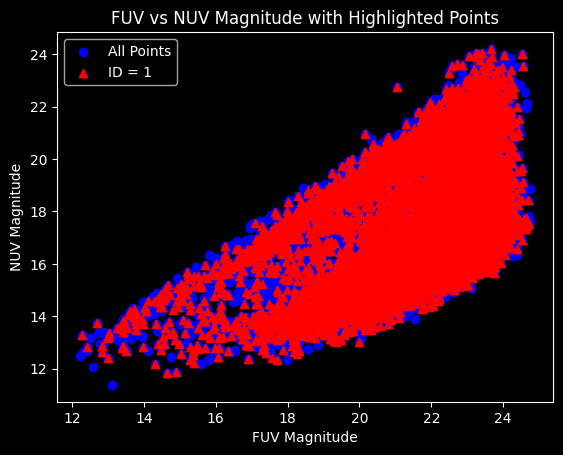

In [55]:
import matplotlib.pyplot as plt
test_fuv = test["fuv_mag"]
test_nuv = test["nuv_mag"]
id = sample["0"]
highlight_fuv = test_fuv[id == 1]
highlight_nuv = test_nuv[id == 1]

# Plot
plt.style.use("dark_background")

# Main scatter plot (all points with dots)
plt.scatter(test_fuv, test_nuv, label="All Points", color="blue")

# Overlay scatter plot for highlighted points (triangles)
plt.scatter(highlight_fuv, highlight_nuv, marker="^", color="red", label="ID = 1")

# Add labels, legend, and title
plt.xlabel("FUV Magnitude")
plt.ylabel("NUV Magnitude")
plt.title("FUV vs NUV Magnitude with Highlighted Points")
plt.legend()